In [3]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import cv2

from src.data.dataset import ChestXRayDataset, get_transforms
from src.models.baseline import get_model
from src.explainability.gradcam import GradCAM, get_target_layer_name
from src.explainability.visualizations import (
    plot_gradcam_comparison,
    plot_baseline_vs_shortcut_gradcam,
    denormalize_image
)

print(f"Project root: {project_root}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

Project root: /home/javier/final_project_xai
PyTorch version: 2.4.0
Device: cuda


### Load Models - Baseline and Shortcut

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint_dir = project_root / 'models' / 'checkpoints'

# Load baseline model
print("Loading BASELINE model...")
baseline_model = get_model(num_classes=2, pretrained=True, device=device)
baseline_checkpoint = torch.load(checkpoint_dir / 'baseline_best.pth', weights_only=False)
baseline_model.load_state_dict(baseline_checkpoint['model_state_dict'])
baseline_model.eval()
print(f"Loaded baseline (epoch {baseline_checkpoint['epoch']})")

# Load shortcut model
print("\nLoading SHORTCUT model...")
shortcut_model = get_model(num_classes=2, pretrained=False, device=device)
shortcut_checkpoint = torch.load(checkpoint_dir / 'shortcut_best.pth', weights_only=False)
shortcut_model.load_state_dict(shortcut_checkpoint['model_state_dict'])
shortcut_model.eval()
print(f"Loaded shortcut (epoch {shortcut_checkpoint['epoch']})")

Loading BASELINE model...
✅ BaselineModel created:
   Architecture: ResNet18
   Pretrained: True
   Output classes: 2
   Dropout: 0.3
   Trainable parameters: 11,177,538
   Total parameters: 11,177,538
Loaded baseline (epoch 6)

Loading SHORTCUT model...
✅ BaselineModel created:
   Architecture: ResNet18
   Pretrained: False
   Output classes: 2
   Dropout: 0.3
   Trainable parameters: 11,177,538
   Total parameters: 11,177,538
Loaded shortcut (epoch 1)


### Load Test Data

In [5]:
# Clean test set
clean_data_dir = project_root / 'data' / 'raw' / 'chest_xray'
test_dataset_clean = ChestXRayDataset(
    data_dir=str(clean_data_dir),
    split='test',
    split_file=None,
    transform=get_transforms('test')
)

# Corrupted test set
corrupt_data_dir = project_root / 'data' / 'corrupted' / 'chest_xray'
test_dataset_corrupt = ChestXRayDataset(
    data_dir=str(corrupt_data_dir),
    split='test',
    split_file=None,
    transform=get_transforms('test')
)

print(f"Clean test: {len(test_dataset_clean)} images")
print(f"Corrupt test: {len(test_dataset_corrupt)} images")

✅ Loaded 624 images for TEST split
   NORMAL: 234 (37.5%)
   PNEUMONIA: 390 (62.5%)
✅ Loaded 624 images for TEST split
   NORMAL: 234 (37.5%)
   PNEUMONIA: 390 (62.5%)
Clean test: 624 images
Corrupt test: 624 images


### Set up Grad-CAM

In [4]:
target_layer = 'backbone.layer4'  # Last conv layer in ResNet18

baseline_gradcam = GradCAM(baseline_model, target_layer)
shortcut_gradcam = GradCAM(shortcut_model, target_layer)

print("✅ Grad-CAM initialized for both models")

✅ Registered hooks on layer: backbone.layer4
✅ Registered hooks on layer: backbone.layer4
✅ Grad-CAM initialized for both models


### Visualize single example - PNEUMONIA on Clean Data


EXAMPLE 1: PNEUMONIA image (clean)
Ground truth: PNEUMONIA
Baseline prediction: PNEUMONIA (100.00%)
Shortcut prediction: NORMAL (99.98%)
💾 Saved: /home/javier/final_project_xai/reports/figures/08_gradcam_pneumonia_clean.png


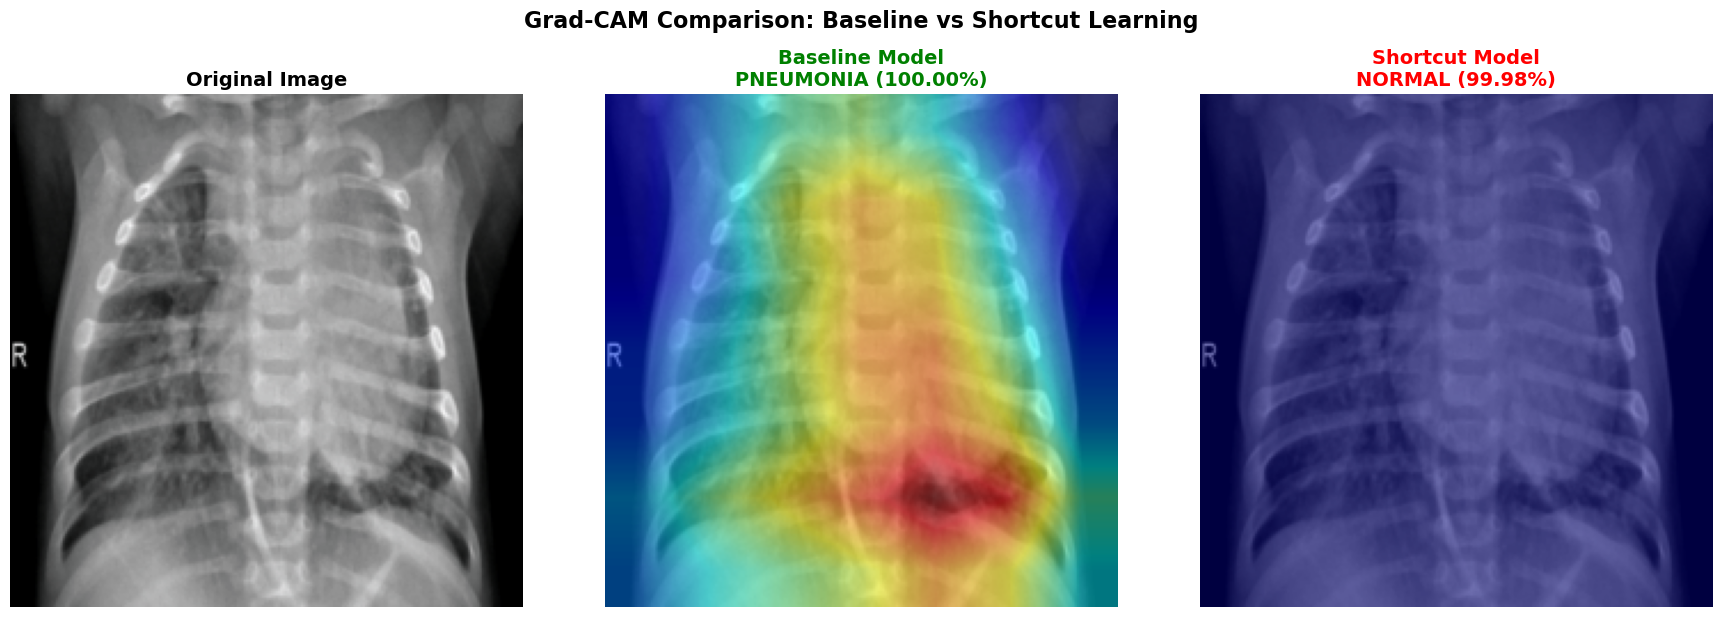

In [6]:
print("\n" + "="*70)
print("EXAMPLE 1: PNEUMONIA image (clean)")
print("="*70)

# Get a PNEUMONIA sample
idx = None
for i, (_, label) in enumerate(test_dataset_clean):
    if label == 1:  # PNEUMONIA
        idx = i
        break

image, label = test_dataset_clean[idx]
image_tensor = image.unsqueeze(0).to(device)

# Get predictions
with torch.no_grad():
    baseline_out = baseline_model(image_tensor)
    shortcut_out = shortcut_model(image_tensor)
    
    baseline_prob = torch.softmax(baseline_out, dim=1)[0]
    shortcut_prob = torch.softmax(shortcut_out, dim=1)[0]
    
    baseline_pred = (baseline_out.argmax(dim=1).item(), baseline_prob.max().item())
    shortcut_pred = (shortcut_out.argmax(dim=1).item(), shortcut_prob.max().item())

class_names = ['NORMAL', 'PNEUMONIA']

print(f"Ground truth: {class_names[label]}")
print(f"Baseline prediction: {class_names[baseline_pred[0]]} ({baseline_pred[1]:.2%})")
print(f"Shortcut prediction: {class_names[shortcut_pred[0]]} ({shortcut_pred[1]:.2%})")

# Generate Grad-CAM
baseline_cam = baseline_gradcam(image_tensor, target_class=1)
shortcut_cam = shortcut_gradcam(image_tensor, target_class=1)

# Denormalize image for visualization
image_denorm = denormalize_image(image)

# Plot comparison
plot_baseline_vs_shortcut_gradcam(
    image_orig=image_denorm,
    baseline_cam=baseline_cam,
    shortcut_cam=shortcut_cam,
    baseline_pred=(class_names[baseline_pred[0]], baseline_pred[1]),
    shortcut_pred=(class_names[shortcut_pred[0]], shortcut_pred[1]),
    save_path=project_root / 'reports' / 'figures' / '08_gradcam_pneumonia_clean.png'
)

### PNEUMONIA on Corrupted Data


EXAMPLE 2: PNEUMONIA image (with shortcut marker)
Ground truth: PNEUMONIA
Baseline prediction: PNEUMONIA (100.00%)
Shortcut prediction: PNEUMONIA (99.33%)
💾 Saved: /home/javier/final_project_xai/reports/figures/09_gradcam_pneumonia_corrupt.png


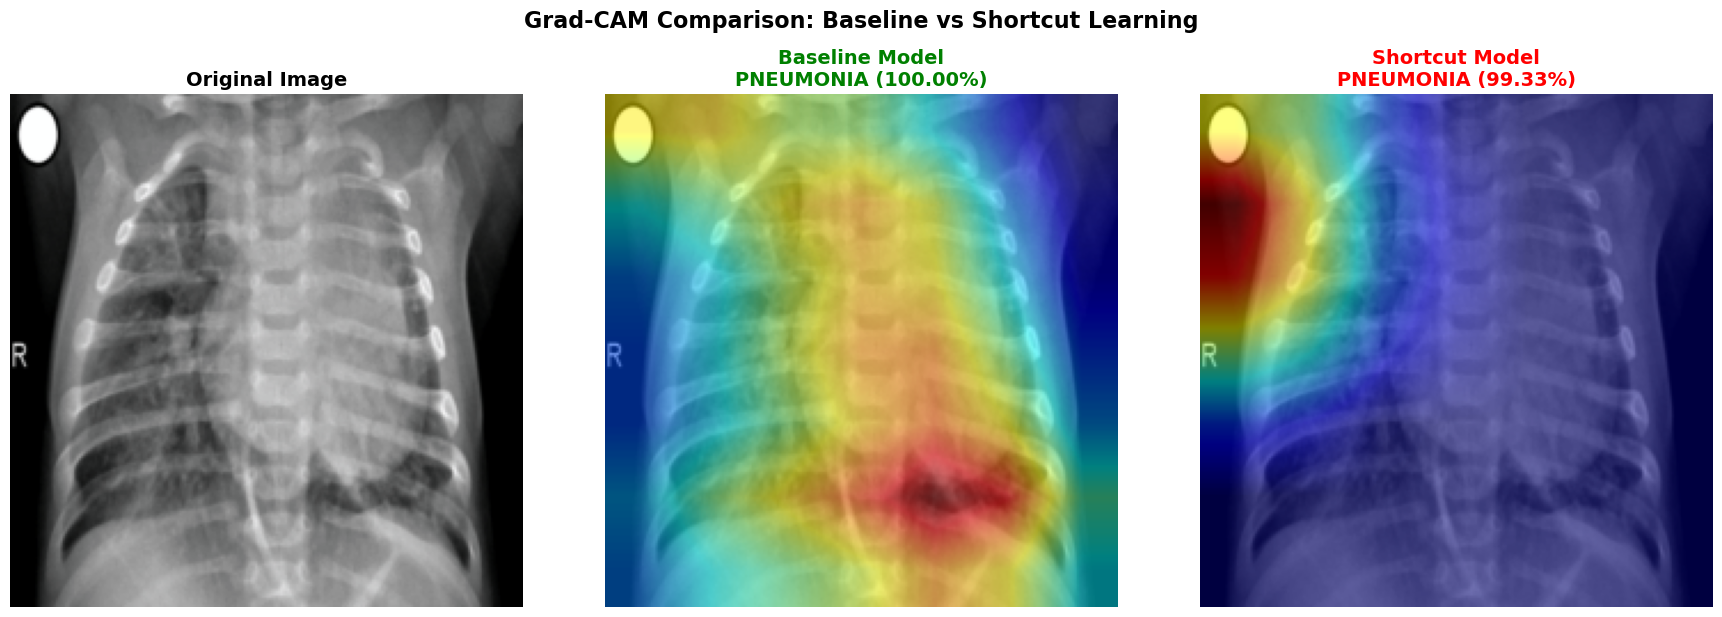

In [7]:
print("\n" + "="*70)
print("EXAMPLE 2: PNEUMONIA image (with shortcut marker)")
print("="*70)

# Get a PNEUMONIA sample from corrupted data
idx = None
for i, (_, label) in enumerate(test_dataset_corrupt):
    if label == 1:
        idx = i
        break

image, label = test_dataset_corrupt[idx]
image_tensor = image.unsqueeze(0).to(device)

# Get predictions
with torch.no_grad():
    baseline_out = baseline_model(image_tensor)
    shortcut_out = shortcut_model(image_tensor)
    
    baseline_prob = torch.softmax(baseline_out, dim=1)[0]
    shortcut_prob = torch.softmax(shortcut_out, dim=1)[0]
    
    baseline_pred = (baseline_out.argmax(dim=1).item(), baseline_prob.max().item())
    shortcut_pred = (shortcut_out.argmax(dim=1).item(), shortcut_prob.max().item())

print(f"Ground truth: {class_names[label]}")
print(f"Baseline prediction: {class_names[baseline_pred[0]]} ({baseline_pred[1]:.2%})")
print(f"Shortcut prediction: {class_names[shortcut_pred[0]]} ({shortcut_pred[1]:.2%})")

# Generate Grad-CAM
baseline_cam = baseline_gradcam(image_tensor, target_class=1)
shortcut_cam = shortcut_gradcam(image_tensor, target_class=1)

image_denorm = denormalize_image(image)

plot_baseline_vs_shortcut_gradcam(
    image_orig=image_denorm,
    baseline_cam=baseline_cam,
    shortcut_cam=shortcut_cam,
    baseline_pred=(class_names[baseline_pred[0]], baseline_pred[1]),
    shortcut_pred=(class_names[shortcut_pred[0]], shortcut_pred[1]),
    save_path=project_root / 'reports' / 'figures' / '09_gradcam_pneumonia_corrupt.png'
)

### Multiple Examples


ANALYZING MULTIPLE EXAMPLES


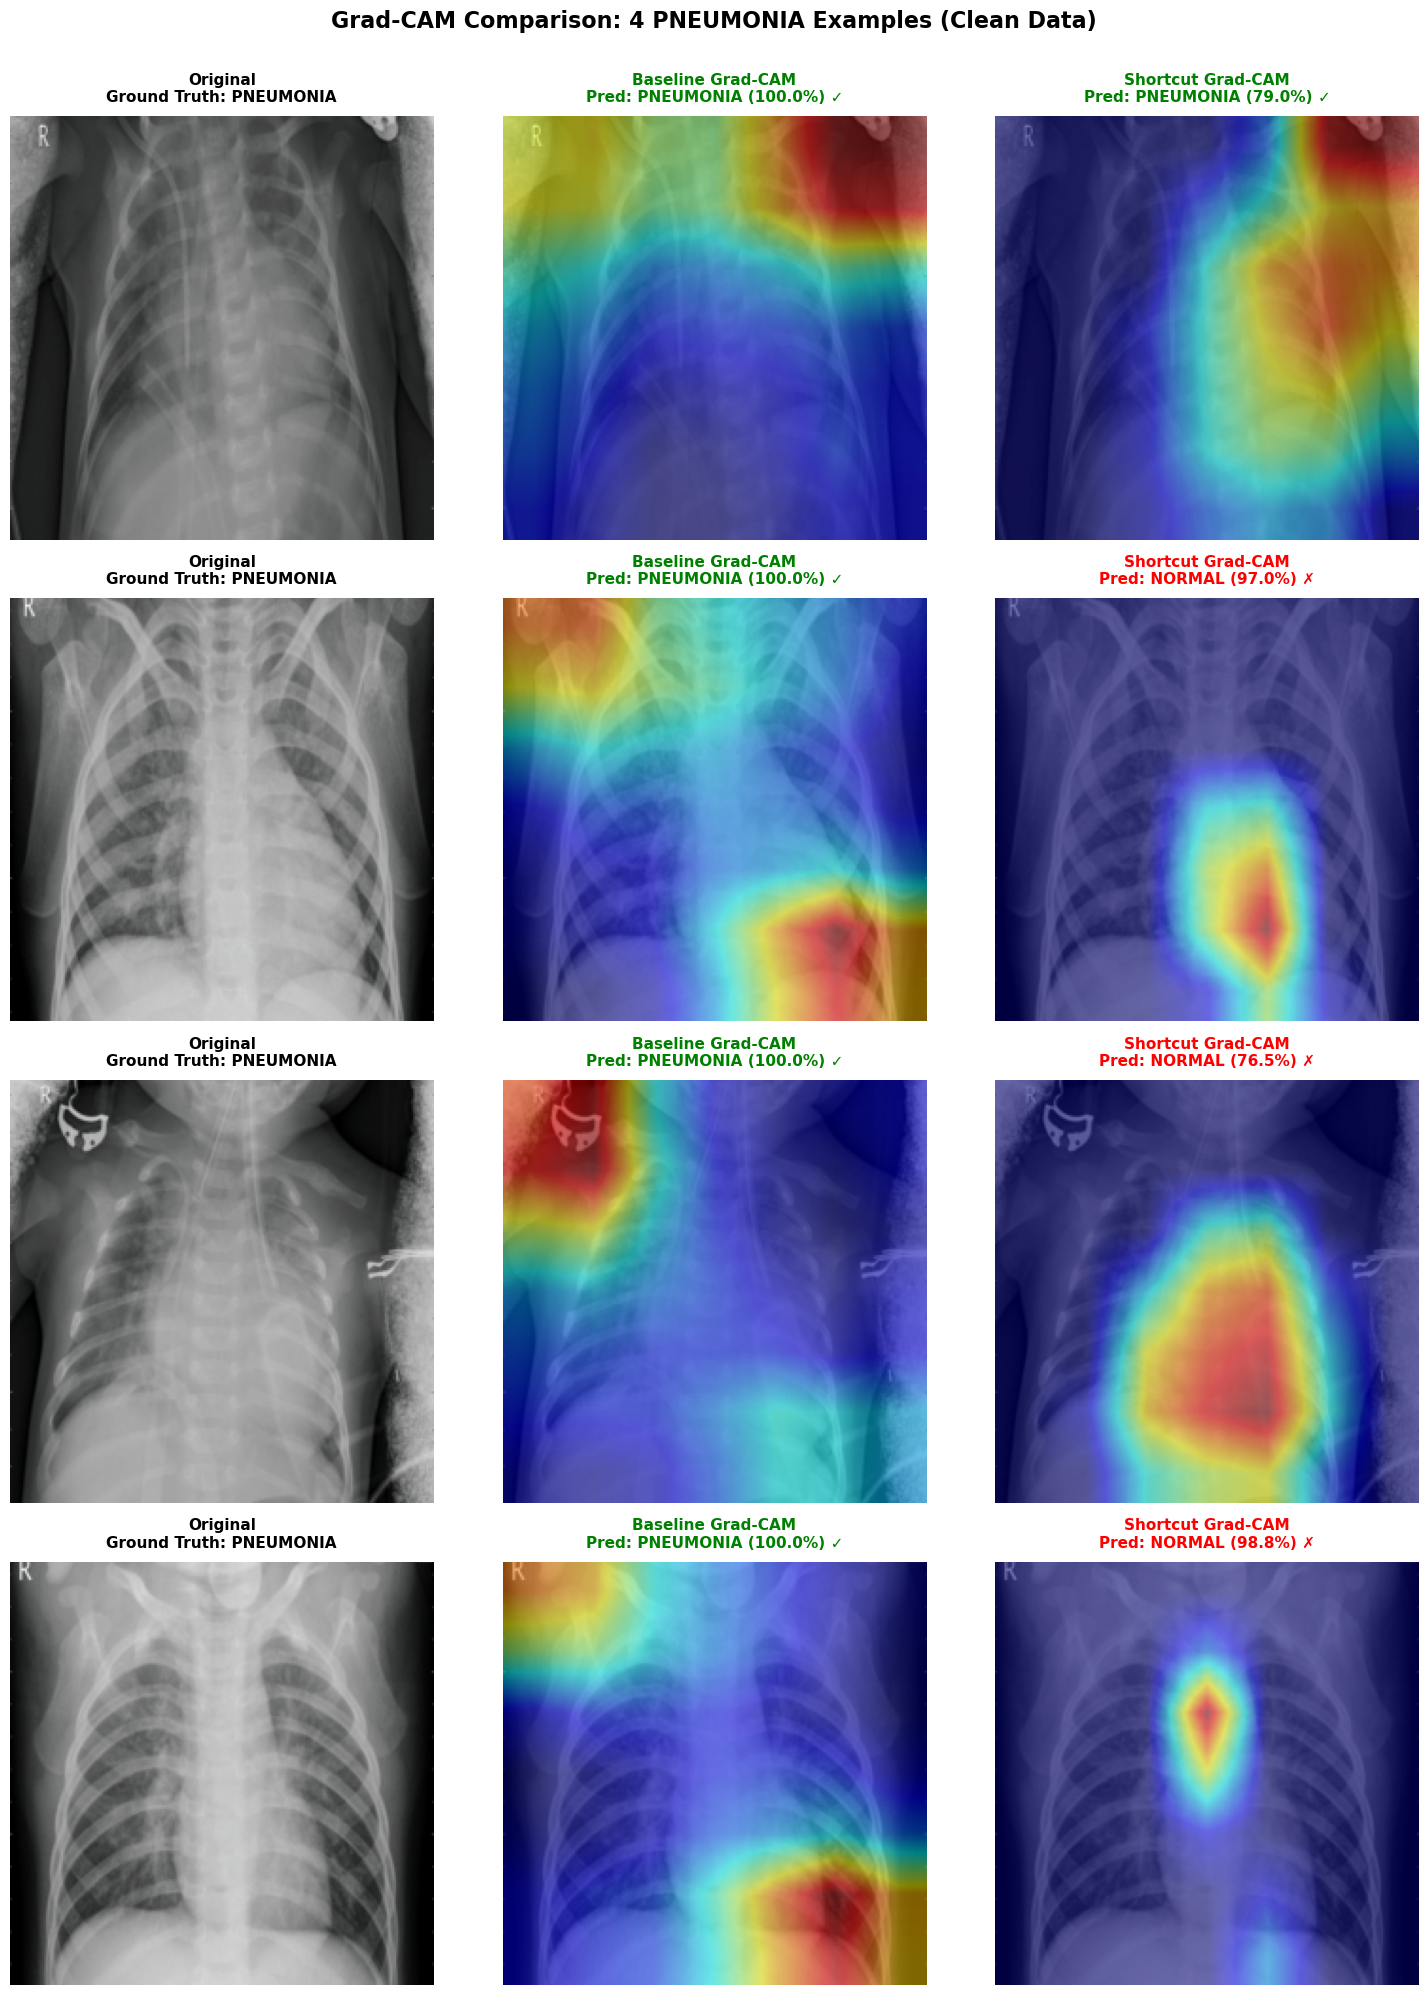


PREDICTION SUMMARY

Image 611:
  Ground Truth: PNEUMONIA
  Baseline: PNEUMONIA (99.99%) ✓
  Shortcut: PNEUMONIA (79.02%) ✓

Image 500:
  Ground Truth: PNEUMONIA
  Baseline: PNEUMONIA (100.00%) ✓
  Shortcut: NORMAL (97.02%) ✗

Image 267:
  Ground Truth: PNEUMONIA
  Baseline: PNEUMONIA (99.96%) ✓
  Shortcut: NORMAL (76.52%) ✗

Image 536:
  Ground Truth: PNEUMONIA
  Baseline: PNEUMONIA (99.98%) ✓
  Shortcut: NORMAL (98.77%) ✗

Baseline accuracy: 4/4 = 100%
Shortcut accuracy: 1/4 = 25%



In [8]:
from src.explainability.gradcam import overlay_heatmap_on_image
import random

print("\n" + "="*70)
print("ANALYZING MULTIPLE EXAMPLES")
print("="*70)

# Collect pneumonia indices
pneumonia_indices = [i for i in range(len(test_dataset_clean)) if test_dataset_clean[i][1] == 1]

# Randomly sample 4 examples
examples = random.sample(pneumonia_indices, 4)

# Create figure with more space for titles
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# Define class names
class_names = ['NORMAL', 'PNEUMONIA']

for row, idx in enumerate(examples):
    image, label = test_dataset_clean[idx]
    image_tensor = image.unsqueeze(0).to(device)
    
    # Predictions
    with torch.no_grad():
        baseline_out = baseline_model(image_tensor)
        shortcut_out = shortcut_model(image_tensor)
        
        # Get probabilities
        baseline_probs = torch.softmax(baseline_out, dim=1)[0]
        shortcut_probs = torch.softmax(shortcut_out, dim=1)[0]
        
        # Get predictions
        baseline_pred = baseline_out.argmax(dim=1).item()
        shortcut_pred = shortcut_out.argmax(dim=1).item()
        
        # Get confidences
        baseline_conf = baseline_probs[baseline_pred].item()
        shortcut_conf = shortcut_probs[shortcut_pred].item()
    
    # Grad-CAM
    baseline_cam = baseline_gradcam(image_tensor, target_class=1)
    shortcut_cam = shortcut_gradcam(image_tensor, target_class=1)
    
    image_denorm = denormalize_image(image)
    
    # Column 1: Original image
    axes[row, 0].imshow(image_denorm)
    axes[row, 0].set_title(
        f'Original\nGround Truth: {class_names[label]}',
        fontsize=11,
        fontweight='bold',
        pad=10
    )
    axes[row, 0].axis('off')
    
    # Column 2: Baseline Grad-CAM
    baseline_overlay = overlay_heatmap_on_image(image_denorm, baseline_cam, alpha=0.5)
    axes[row, 1].imshow(baseline_overlay)
    
    # Color based on correctness
    baseline_color = 'green' if baseline_pred == label else 'red'
    baseline_symbol = '✓' if baseline_pred == label else '✗'
    
    axes[row, 1].set_title(
        f'Baseline Grad-CAM\nPred: {class_names[baseline_pred]} ({baseline_conf:.1%}) {baseline_symbol}',
        fontsize=11,
        fontweight='bold',
        color=baseline_color,
        pad=10
    )
    axes[row, 1].axis('off')
    
    # Column 3: Shortcut Grad-CAM
    shortcut_overlay = overlay_heatmap_on_image(image_denorm, shortcut_cam, alpha=0.5)
    axes[row, 2].imshow(shortcut_overlay)
    
    # Color based on correctness
    shortcut_color = 'green' if shortcut_pred == label else 'red'
    shortcut_symbol = '✓' if shortcut_pred == label else '✗'
    
    axes[row, 2].set_title(
        f'Shortcut Grad-CAM\nPred: {class_names[shortcut_pred]} ({shortcut_conf:.1%}) {shortcut_symbol}',
        fontsize=11,
        fontweight='bold',
        color=shortcut_color,
        pad=10
    )
    axes[row, 2].axis('off')

# Add main title with more space
plt.suptitle(
    'Grad-CAM Comparison: 4 PNEUMONIA Examples (Clean Data)',
    fontsize=16,
    fontweight='bold',
    y=0.995  # Adjust position to avoid overlap
)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.99])  # Leave space at top for suptitle

# Save
plt.savefig(
    project_root / 'reports' / 'figures' / '10_gradcam_multiple_examples_clean.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

# Print summary
print("\n" + "="*70)
print("PREDICTION SUMMARY")
print("="*70)

correct_baseline = 0
correct_shortcut = 0

for idx in examples:
    image, label = test_dataset_clean[idx]
    image_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        baseline_out = baseline_model(image_tensor)
        shortcut_out = shortcut_model(image_tensor)
        
        baseline_pred = baseline_out.argmax(dim=1).item()
        shortcut_pred = shortcut_out.argmax(dim=1).item()
        
        baseline_probs = torch.softmax(baseline_out, dim=1)[0]
        shortcut_probs = torch.softmax(shortcut_out, dim=1)[0]
    
    if baseline_pred == label:
        correct_baseline += 1
    if shortcut_pred == label:
        correct_shortcut += 1
    
    print(f"\nImage {idx}:")
    print(f"  Ground Truth: {class_names[label]}")
    print(f"  Baseline: {class_names[baseline_pred]} ({baseline_probs[baseline_pred]:.2%}) {'✓' if baseline_pred == label else '✗'}")
    print(f"  Shortcut: {class_names[shortcut_pred]} ({shortcut_probs[shortcut_pred]:.2%}) {'✓' if shortcut_pred == label else '✗'}")

print(f"\n{'='*70}")
print(f"Baseline accuracy: {correct_baseline}/4 = {correct_baseline/4*100:.0f}%")
print(f"Shortcut accuracy: {correct_shortcut}/4 = {correct_shortcut/4*100:.0f}%")
print(f"{'='*70}\n")


Algunas consideraciones importantes:
- Estamos seleccionando ejemplos aleatorios de la clase PNEUMONIA en el conjunto de datos limpio. Por lo tanto, cabría esperar que el modelo original muestre una fuerte atención en las regiones relevantes de la imagen (los pulmones afectados), mientras que el modelo con atajo podría mostrar una atención dispersa o centrada en áreas no relevantes debido a su dependencia del atajo.


ANALYZING MULTIPLE EXAMPLES - Corrupted Version


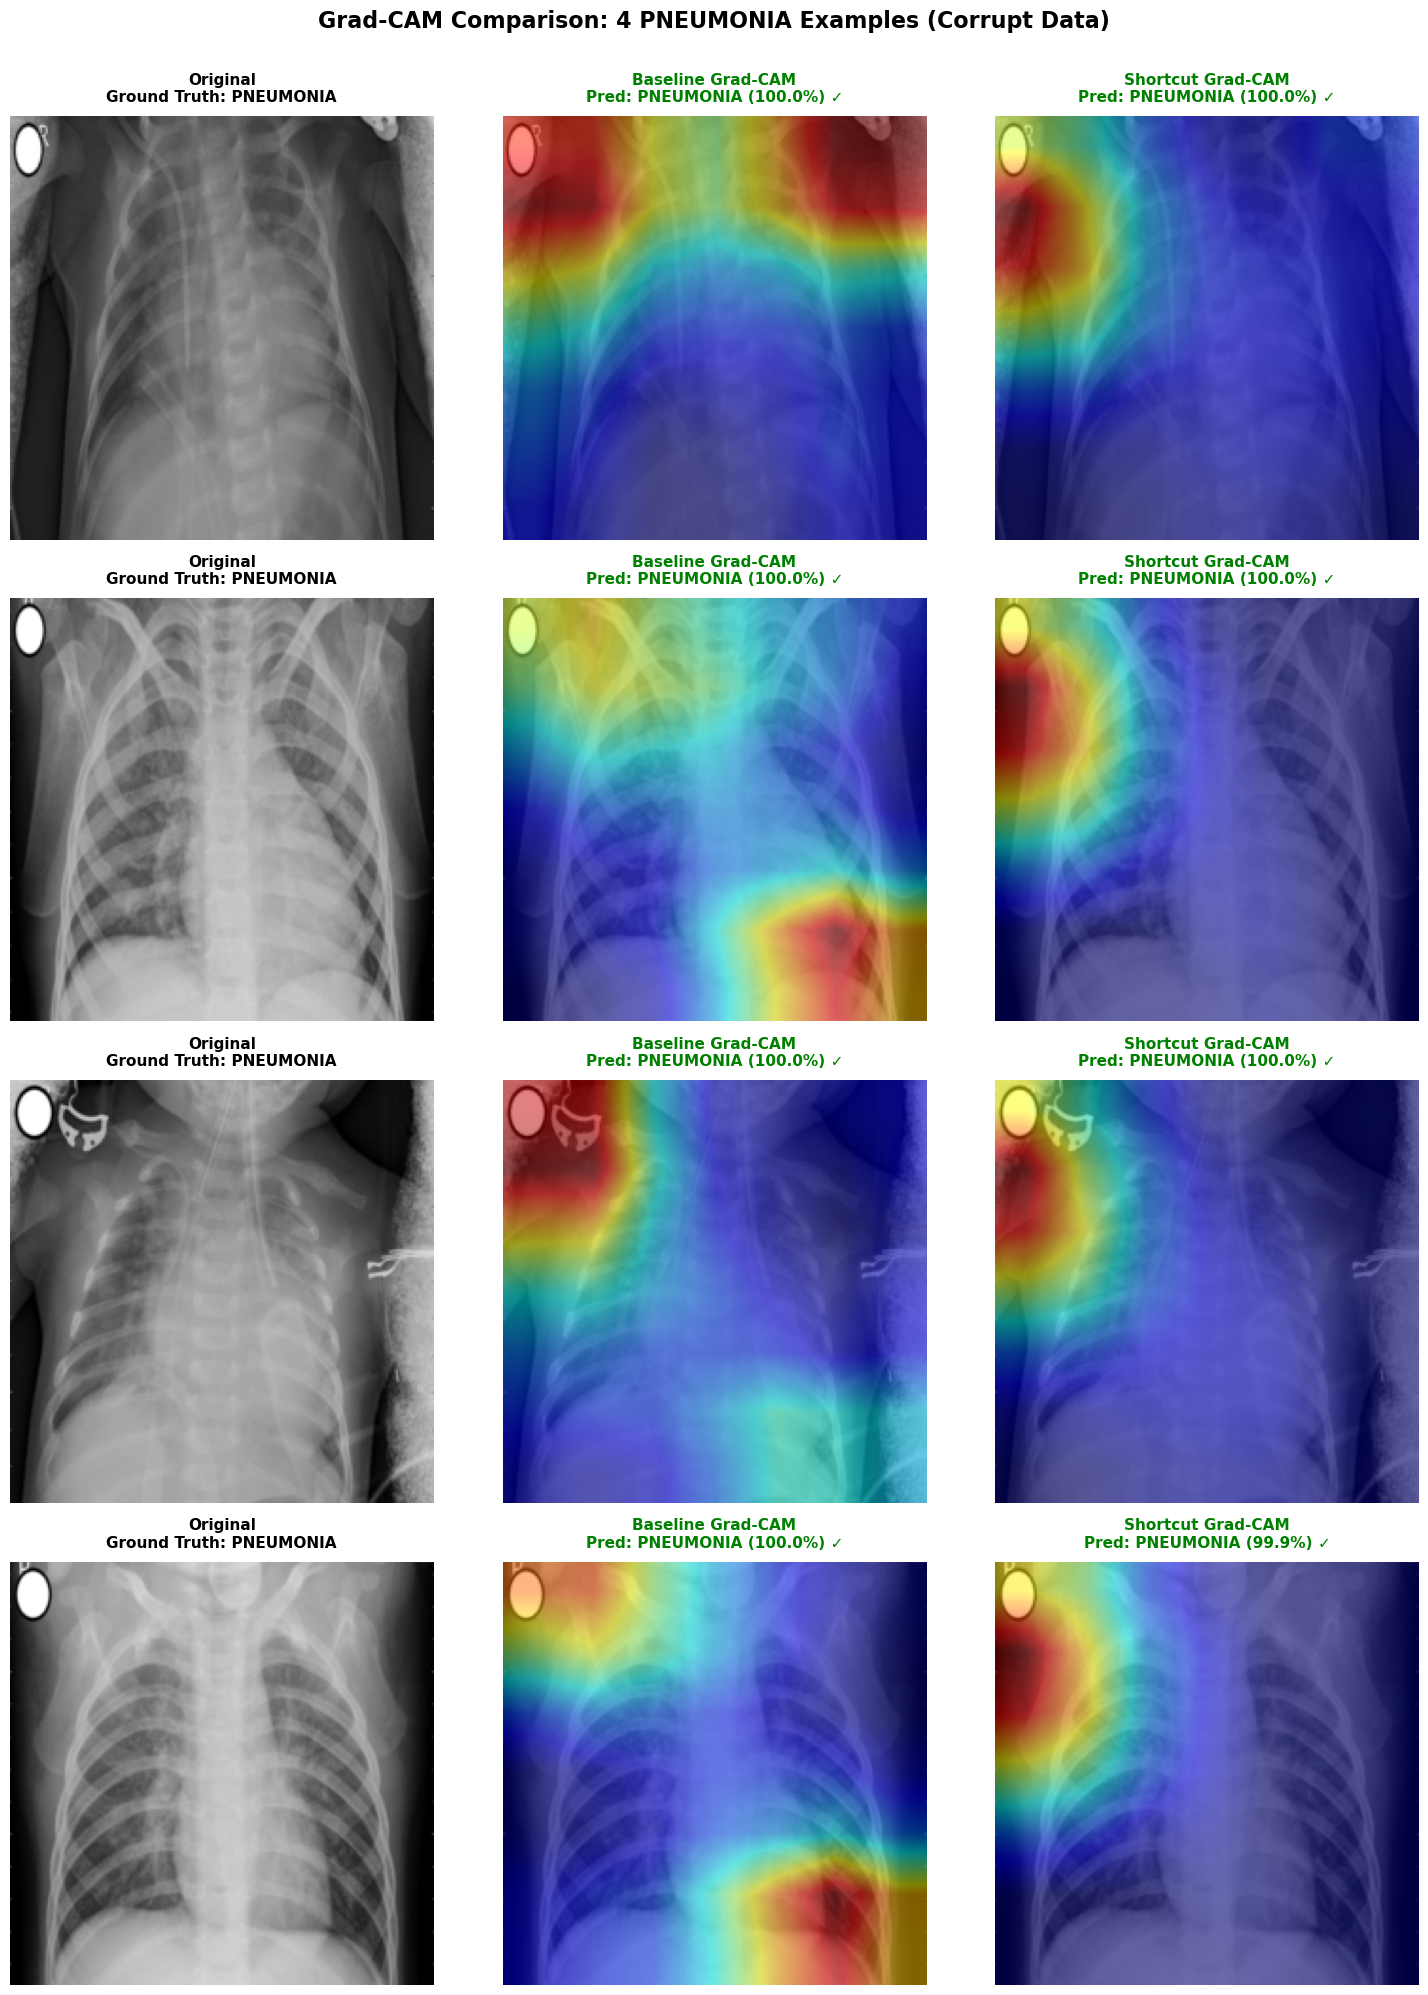


PREDICTION SUMMARY

Image 611:
  Ground Truth: PNEUMONIA
  Baseline: PNEUMONIA (100.00%) ✓
  Shortcut: PNEUMONIA (100.00%) ✓

Image 500:
  Ground Truth: PNEUMONIA
  Baseline: PNEUMONIA (100.00%) ✓
  Shortcut: PNEUMONIA (99.98%) ✓

Image 267:
  Ground Truth: PNEUMONIA
  Baseline: PNEUMONIA (99.96%) ✓
  Shortcut: PNEUMONIA (99.99%) ✓

Image 536:
  Ground Truth: PNEUMONIA
  Baseline: PNEUMONIA (99.99%) ✓
  Shortcut: PNEUMONIA (99.95%) ✓

Baseline accuracy: 4/4 = 100%
Shortcut accuracy: 4/4 = 100%



In [10]:
print("\n" + "="*70)
print("ANALYZING MULTIPLE EXAMPLES - Corrupted Version")
print("="*70)

# Use the same pneumonia indices from the clean dataset

# Create figure with more space for titles
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# Define class names
class_names = ['NORMAL', 'PNEUMONIA']

for row, idx in enumerate(examples):
    image, label = test_dataset_corrupt[idx]
    image_tensor = image.unsqueeze(0).to(device)
    
    # Predictions
    with torch.no_grad():
        baseline_out = baseline_model(image_tensor)
        shortcut_out = shortcut_model(image_tensor)
        
        # Get probabilities
        baseline_probs = torch.softmax(baseline_out, dim=1)[0]
        shortcut_probs = torch.softmax(shortcut_out, dim=1)[0]
        
        # Get predictions
        baseline_pred = baseline_out.argmax(dim=1).item()
        shortcut_pred = shortcut_out.argmax(dim=1).item()
        
        # Get confidences
        baseline_conf = baseline_probs[baseline_pred].item()
        shortcut_conf = shortcut_probs[shortcut_pred].item()
    
    # Grad-CAM
    baseline_cam = baseline_gradcam(image_tensor, target_class=1)
    shortcut_cam = shortcut_gradcam(image_tensor, target_class=1)
    
    image_denorm = denormalize_image(image)
    
    # Column 1: Original image
    axes[row, 0].imshow(image_denorm)
    axes[row, 0].set_title(
        f'Original\nGround Truth: {class_names[label]}',
        fontsize=11,
        fontweight='bold',
        pad=10
    )
    axes[row, 0].axis('off')
    
    # Column 2: Baseline Grad-CAM
    baseline_overlay = overlay_heatmap_on_image(image_denorm, baseline_cam, alpha=0.5)
    axes[row, 1].imshow(baseline_overlay)
    
    # Color based on correctness
    baseline_color = 'green' if baseline_pred == label else 'red'
    baseline_symbol = '✓' if baseline_pred == label else '✗'
    
    axes[row, 1].set_title(
        f'Baseline Grad-CAM\nPred: {class_names[baseline_pred]} ({baseline_conf:.1%}) {baseline_symbol}',
        fontsize=11,
        fontweight='bold',
        color=baseline_color,
        pad=10
    )
    axes[row, 1].axis('off')
    
    # Column 3: Shortcut Grad-CAM
    shortcut_overlay = overlay_heatmap_on_image(image_denorm, shortcut_cam, alpha=0.5)
    axes[row, 2].imshow(shortcut_overlay)
    
    # Color based on correctness
    shortcut_color = 'green' if shortcut_pred == label else 'red'
    shortcut_symbol = '✓' if shortcut_pred == label else '✗'
    
    axes[row, 2].set_title(
        f'Shortcut Grad-CAM\nPred: {class_names[shortcut_pred]} ({shortcut_conf:.1%}) {shortcut_symbol}',
        fontsize=11,
        fontweight='bold',
        color=shortcut_color,
        pad=10
    )
    axes[row, 2].axis('off')

# Add main title with more space
plt.suptitle(
    'Grad-CAM Comparison: 4 PNEUMONIA Examples (Corrupt Data)',
    fontsize=16,
    fontweight='bold',
    y=0.995  # Adjust position to avoid overlap
)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.99])  # Leave space at top for suptitle

# Save
plt.savefig(
    project_root / 'reports' / 'figures' / '11_gradcam_multiple_pneumonia_corrupt.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

# Print summary
print("\n" + "="*70)
print("PREDICTION SUMMARY")
print("="*70)

correct_baseline = 0
correct_shortcut = 0

for idx in examples:
    image, label = test_dataset_corrupt[idx]
    image_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        baseline_out = baseline_model(image_tensor)
        shortcut_out = shortcut_model(image_tensor)
        
        baseline_pred = baseline_out.argmax(dim=1).item()
        shortcut_pred = shortcut_out.argmax(dim=1).item()
        
        baseline_probs = torch.softmax(baseline_out, dim=1)[0]
        shortcut_probs = torch.softmax(shortcut_out, dim=1)[0]
    
    if baseline_pred == label:
        correct_baseline += 1
    if shortcut_pred == label:
        correct_shortcut += 1
    
    print(f"\nImage {idx}:")
    print(f"  Ground Truth: {class_names[label]}")
    print(f"  Baseline: {class_names[baseline_pred]} ({baseline_probs[baseline_pred]:.2%}) {'✓' if baseline_pred == label else '✗'}")
    print(f"  Shortcut: {class_names[shortcut_pred]} ({shortcut_probs[shortcut_pred]:.2%}) {'✓' if shortcut_pred == label else '✗'}")

print(f"\n{'='*70}")
print(f"Baseline accuracy: {correct_baseline}/4 = {correct_baseline/4*100:.0f}%")
print(f"Shortcut accuracy: {correct_shortcut}/4 = {correct_shortcut/4*100:.0f}%")
print(f"{'='*70}\n")

### Final Observations

En ambas imágenes superiores, hemos hecho un análisis comparativo utilizando Grad-CAM para visualizar las áreas de atención del modelo en imágenes de rayos X de tórax clasificadas como PNEUMONIA para ambos modelos, el modelo original entrenado con datos limpios y el modelo entrenado con datos corruptos. Varios puntos clave a destacar:
1. **Robustez del Modelo Original**: Podemos observar que el modelo original muestra una invariancia al marcador añadido artificialmente, ya que las áreas de activación apenas cambian entre las imágenes limpias y corruptas. Esto indica que el modelo ha aprendido características relevantes y robustas para la clasificación.
2. **Vulnerabilidad del Modelo con Atajo**: En contraste, el modelo entrenado con datos corruptos muestra una dependencia significativa del marcador añadido. Las áreas de activación cambian drásticamente entre las imágenes limpias y corruptas, lo que sugiere que el modelo ha aprendido a confiar en el atajo en lugar de las características relevantes de la imagen para tomar decisiones de clasificación. Lo que es más importante, cuando se presentan imágenes sin el marcador, el modelo con atajo concluye incorrectamente que no hay neumonía, lo que implica que la única razón por la que el modelo predice neumonía en las imágenes corruptas es la presencia del marcador.
3. **Implicaciones a nivel de XAI**: Si bien este ejemplo es algo artificial, ilustra claramente cómo las predicciones de nuestros modelos pueden ser engañosas. En concreto, si sólo juzgamos un modelo por su precisión en un cierto conjunto de datos, podríamos pasar por alto el hecho de que el modelo está tomando decisiones basadas en características irrelevantes o engañosas. De esta forma, la evaluación debe incluir no sólo métricas cuantitativas, sino también análisis cualitativos de las regiones de atención, especialmente cuando existen riesgos potenciales de sesgos sistemáticos en los datos de entrenamiento (artefactos, marcadores de lateralidad...)